# Quail segmentation and feature extraction exploration #

*5 January 2023*

Co-coding with Robert Haase.

## Import tools ##

In [2]:
from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.3
import napari
import pyclesperanto_prototype as cle  # version 0.21.2
import pandas as pd
from napari_simpleitk_image_processing import label_statistics

import napari_skimage_regionprops as nsr

from sklearn.preprocessing import StandardScaler
# import seaborn
import stackview
# import umap
# from numba.np.ufunc import _internal

# if 'viewer' not in globals():
#     viewer = napari.Viewer()


## Read data ##

Cropped data from `220214_highresnode` dataset (Adrian)

In [5]:
stack = imread('data/node_crop_small.tif')
stack.shape

(181, 1134, 1134)

In [ ]:
# type(stack)

In [ ]:
# have a look
frame_100 = stack[100]
# frame_101 = stack[101]

In [ ]:
viewer = napari.Viewer()

In [ ]:
viewer.add_image(
    frame_100,
    colormap='gray_r',
    interpolation3d='bicubic',
    contrast_limits=[0,255],
)

In [ ]:
# image0_f1 = viewer.layers['frame_100'].data

# local minima seeded watershed

frame_100_lmsw = nsbatwm.local_minima_seeded_watershed(frame_100, 25.0, 5.0)

viewer.add_labels(frame_100_lmsw, name='lmsw_25_5')

## Scale 3D data ##

Allows exploration on local mac (M1 or Intel)

In [6]:
voxel_size_xy = 1
voxel_size_z  = 5     # according to Adrian the pixels in this dataset are isotropic
zoom          = 0.25 

cl.OCLArray([[[ 6.,  0.,  2., ...,  4.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  3.,  1.,  0.],
        ...,
        [ 4.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  8.,  4., ..., 18.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 3., 19.,  1., ...,  5.,  1.,  0.],
        [ 0.,  0.,  3., ...,  5.,  0.,  0.],
        [ 1.,  0.,  9., ..., 12.,  1.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  7.,  2.,  0.],
        [ 7.,  0.,  2., ...,  8., 21.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[15.,  7.,  4., ..., 10.,  0.,  0.],
        [ 5.,  4.,  6., ...,  3.,  0.,  0.],
        [ 1.,  3.,  2., ...,  0.,  9.,  0.],
        ...,
        [ 3.,  0.,  1., ...,  4., 34.,  0.],
        [ 0.,  0.,  0., ..., 22.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  4.,  0.],
        [ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 6.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  2., ...,  0.,  1.,  0.],
        [ 1.,  0.,  0., ...,  0., 10.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
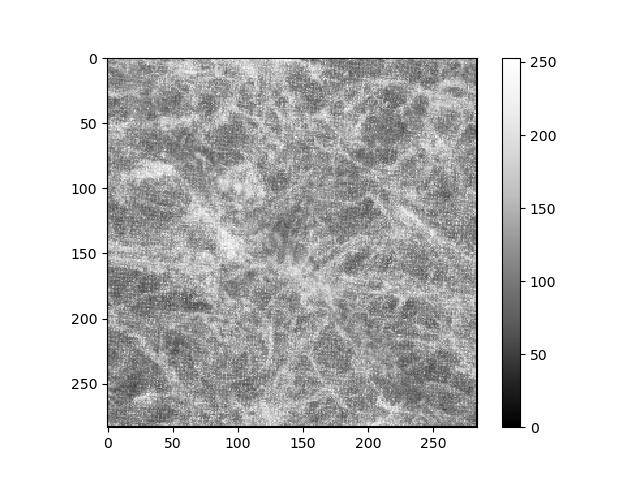
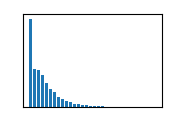

In [7]:
scaled_stack = (
    cle.scale(
        stack, 
        factor_x=voxel_size_xy*zoom, 
        factor_y=voxel_size_xy*zoom, 
        factor_z=voxel_size_z*zoom, 
        auto_size=True,
        # linear_interpolation=True # linear interpolation not supported on intel cpu
    ) 
)
scaled_stack

In [8]:
# visualize in napari 
viewer_3d = napari.Viewer()
scaled_stack_layer = (
    viewer_3d.add_image(
        scaled_stack, 
        colormap='gray_r',
        interpolation3d='bicubic',
        contrast_limits=[0,255],
    )
)

## Local minima seeded watershed in 3D ##

Uses 3D data.  Local minima are regions between membranes as seed.

In [9]:
lmsw_3d = nsbatwm.local_minima_seeded_watershed(scaled_stack, 25.0*zoom, 5.0*zoom)

In [10]:
# lmsw_labels = viewer_3d.add_labels(lmsw_3d)

In [11]:
# exclude labels on the edge of the stack
exclude_labels_on_edges = cle.exclude_labels_on_edges(lmsw_3d)
# viewer.add_labels(
#     exclude_labels_on_edges, name='Result of exclude_labels_on_edges (clesperanto)')

In [12]:
# exclude small labels
exclude_small_labels = cle.exclude_small_labels(exclude_labels_on_edges, None, 100.0) # base small on zoom in future
# viewer.add_labels(
#     exclude_small_labels, name='Result of exclude_small_labels (clesperanto)')

In [13]:
labels_3d_layer = (
    viewer_3d.add_labels(
        exclude_small_labels,
        opacity=0.5,
    )
)

____

# ☟☟☟ Issues with M1 packages begin here ☟☟☟ #

## Label statistics ##

In [ ]:
# cle.available_device_names()

In [ ]:
# cle.select_device('GPU')
# cle.select_device("GTX")
# from pyopencl.cache import create_built_program_from_source_cached
# print(cle.cl_info())

In [ ]:
# cle.statistics_of_labelled_pixels(image1_s, image2_esl)

### Troubleshooting label_statistics ###

The label statistics from simple itk do not work on my M1 iMac:

`from napari_simpleitk_image_processing import label_statistics`  

Workaround using different package:

`import napari_skimage_regionprops as nsr`



In [14]:
# cannot get label_statistics from napari_simpleitk_image_processing to run on M1 mac

statistics = label_statistics(scaled_stack, exclude_small_labels, 
                              intensity=True, 
                              size=True, 
                              shape=True, 
                              perimeter=False, 
                              position=False,
                              moments=False
                             )


UNSUPPORTED (log once): buildComputeProgram: cl2Metal failed


RuntimeError: clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE

Build on <pyopencl.Device 'Apple M1' on 'Apple' at 0x600002d34dc0>:

Compiler encountered an internal error
(options: -I /Users/jwhite/miniforge3/envs/test-env/lib/python3.9/site-packages/pyopencl/cl)
(source saved as /var/folders/vg/pkq1xs_x1b559nk61kjgcgkh0000gn/T/tmpzz6px7_9.cl)

In [ ]:
# nsr.regionprops_table_all_frames??

### M1 mac workaround for label_statistics ###

In [ ]:
# # workaround for M1 mac

# statistics = nsr.regionprops_table(
#     scaled_stack, 
#     exclude_small_labels, 
#     size = True,
#     intensity = True,
#     perimeter = False,
#     shape = True,
#     position = True,
#     moments = True,
# )

## Add statistics to napari viewer ##

In [ ]:
label_statistics_df = pd.DataFrame(statistics)
labels_3d_layer.properties = label_statistics_df
nsr.add_table(labels_3d_layer, viewer_3d)
label_statistics_df

In [ ]:
nsr.add_table(labels_3d_layer, viewer_3d)

## Check label statistics for nans ##

In [ ]:
label_statistics_df.isna().values.any()

In [ ]:
row0 = label_statistics_df.iloc[0]
row0[row0.isna()]

In [ ]:
# # For nsr.region_props_table statistics workaround
# label_statistics_df.drop(columns=['moments_normalized-0-0-0', 'moments_normalized-0-0-1', 'moments_normalized-0-1-0', 'moments_normalized-1-0-0'], inplace=True)

In [ ]:
label_statistics_df[label_statistics_df.isna().any(axis=1)]

In [ ]:
list(label_statistics_df.columns)

In [ ]:
# if using label_statistics from napari_simpleitk_image_processing
selected_table = label_statistics_df[
    [
        # 'label',
         'maximum',
         'mean',
         'median',
         'minimum',
         'sigma',
         'sum',
         'variance',
         'elongation',
         'feret_diameter',
         'flatness',
         # 'roundness',
         'equivalent_ellipsoid_diameter_0',
         'equivalent_ellipsoid_diameter_1',
         'equivalent_ellipsoid_diameter_2',
         'equivalent_spherical_perimeter',
         'equivalent_spherical_radius',
         'number_of_pixels',
         'number_of_pixels_on_border'
    ]
]


In [ ]:
# # For nsr.region_props_table statistics workaround
# selected_table = label_statistics_df[[
#     # 'label',
#      'area',
#      # 'bbox_area',
#      'convex_area',
#      'equivalent_diameter',
#      'max_intensity',
#      'mean_intensity',
#      'min_intensity',
#      'solidity',
#      'extent',
#      'feret_diameter_max',
#      # 'local_centroid-0',
#      # 'local_centroid-1',
#      # 'local_centroid-2',
#      # 'moments_central-0-0-0',
#      # 'moments_central-0-0-1',
#      # 'moments_central-0-0-2',
#      # 'moments_central-0-0-3',
#      # 'moments_central-0-1-0',
#      # 'moments_central-0-1-1',
#      # 'moments_central-0-1-2',
#      # 'moments_central-0-1-3',
#      # 'moments_central-0-2-0',
#      # 'moments_central-0-2-1',
#      # 'moments_central-0-2-2',
#      # 'moments_central-0-2-3',
#      # 'moments_central-0-3-0',
#      # 'moments_central-0-3-1',
#      # 'moments_central-0-3-2',
#      # 'moments_central-0-3-3',
#      # 'moments_central-1-0-0',
#      # 'moments_central-1-0-1',
#      # 'moments_central-1-0-2',
#      # 'moments_central-1-0-3',
#      # 'moments_central-1-1-0',
#      # 'moments_central-1-1-1',
#      # 'moments_central-1-1-2',
#      # 'moments_central-1-1-3',
#      # 'moments_central-1-2-0',
#      # 'moments_central-1-2-1',
#      # 'moments_central-1-2-2',
#      # 'moments_central-1-2-3',
#      # 'moments_central-1-3-0',
#      # 'moments_central-1-3-1',
#      # 'moments_central-1-3-2',
#      # 'moments_central-1-3-3',
#      # 'moments_central-2-0-0',
#      # 'moments_central-2-0-1',
#      # 'moments_central-2-0-2',
#      # 'moments_central-2-0-3',
#      # 'moments_central-2-1-0',
#      # 'moments_central-2-1-1',
#      # 'moments_central-2-1-2',
#      # 'moments_central-2-1-3',
#      # 'moments_central-2-2-0',
#      # 'moments_central-2-2-1',
#      # 'moments_central-2-2-2',
#      # 'moments_central-2-2-3',
#      # 'moments_central-2-3-0',
#      # 'moments_central-2-3-1',
#      # 'moments_central-2-3-2',
#      # 'moments_central-2-3-3',
#      # 'moments_central-3-0-0',
#      # 'moments_central-3-0-1',
#      # 'moments_central-3-0-2',
#      # 'moments_central-3-0-3',
#      # 'moments_central-3-1-0',
#      # 'moments_central-3-1-1',
#      # 'moments_central-3-1-2',
#      # 'moments_central-3-1-3',
#      # 'moments_central-3-2-0',
#      # 'moments_central-3-2-1',
#      # 'moments_central-3-2-2',
#      # 'moments_central-3-2-3',
#      # 'moments_central-3-3-0',
#      # 'moments_central-3-3-1',
#      # 'moments_central-3-3-2',
#      # 'moments_central-3-3-3',
#      # 'centroid-0',
#      # 'centroid-1',
#      # 'centroid-2',
#      # 'bbox-0',
#      # 'bbox-1',
#      # 'bbox-2',
#      # 'bbox-3',
#      # 'bbox-4',
#      # 'bbox-5',
#      # 'weighted_centroid-0',
#      # 'weighted_centroid-1',
#      # 'weighted_centroid-2',
#      # 'moments-0-0-0',
#      # 'moments-0-0-1',
#      # 'moments-0-0-2',
#      # 'moments-0-0-3',
#      # 'moments-0-1-0',
#      # 'moments-0-1-1',
#      # 'moments-0-1-2',
#      # 'moments-0-1-3',
#      # 'moments-0-2-0',
#      # 'moments-0-2-1',
#      # 'moments-0-2-2',
#      # 'moments-0-2-3',
#      # 'moments-0-3-0',
#      # 'moments-0-3-1',
#      # 'moments-0-3-2',
#      # 'moments-0-3-3',
#      # 'moments-1-0-0',
#      # 'moments-1-0-1',
#      # 'moments-1-0-2',
#      # 'moments-1-0-3',
#      # 'moments-1-1-0',
#      # 'moments-1-1-1',
#      # 'moments-1-1-2',
#      # 'moments-1-1-3',
#      # 'moments-1-2-0',
#      # 'moments-1-2-1',
#      # 'moments-1-2-2',
#      # 'moments-1-2-3',
#      # 'moments-1-3-0',
#      # 'moments-1-3-1',
#      # 'moments-1-3-2',
#      # 'moments-1-3-3',
#      # 'moments-2-0-0',
#      # 'moments-2-0-1',
#      # 'moments-2-0-2',
#      # 'moments-2-0-3',
#      # 'moments-2-1-0',
#      # 'moments-2-1-1',
#      # 'moments-2-1-2',
#      # 'moments-2-1-3',
#      # 'moments-2-2-0',
#      # 'moments-2-2-1',
#      # 'moments-2-2-2',
#      # 'moments-2-2-3',
#      # 'moments-2-3-0',
#      # 'moments-2-3-1',
#      # 'moments-2-3-2',
#      # 'moments-2-3-3',
#      # 'moments-3-0-0',
#      # 'moments-3-0-1',
#      # 'moments-3-0-2',
#      # 'moments-3-0-3',
#      # 'moments-3-1-0',
#      # 'moments-3-1-1',
#      # 'moments-3-1-2',
#      # 'moments-3-1-3',
#      # 'moments-3-2-0',
#      # 'moments-3-2-1',
#      # 'moments-3-2-2',
#      # 'moments-3-2-3',
#      # 'moments-3-3-0',
#      # 'moments-3-3-1',
#      # 'moments-3-3-2',
#      # 'moments-3-3-3',
#      # 'moments_normalized-0-0-2',
#      # 'moments_normalized-0-0-3',
#      # 'moments_normalized-0-1-1',
#      # 'moments_normalized-0-1-2',
#      # 'moments_normalized-0-1-3',
#      # 'moments_normalized-0-2-0',
#      # 'moments_normalized-0-2-1',
#      # 'moments_normalized-0-2-2',
#      # 'moments_normalized-0-2-3',
#      # 'moments_normalized-0-3-0',
#      # 'moments_normalized-0-3-1',
#      # 'moments_normalized-0-3-2',
#      # 'moments_normalized-0-3-3',
#      # 'moments_normalized-1-0-1',
#      # 'moments_normalized-1-0-2',
#      # 'moments_normalized-1-0-3',
#      # 'moments_normalized-1-1-0',
#      # 'moments_normalized-1-1-1',
#      # 'moments_normalized-1-1-2',
#      # 'moments_normalized-1-1-3',
#      # 'moments_normalized-1-2-0',
#      # 'moments_normalized-1-2-1',
#      # 'moments_normalized-1-2-2',
#      # 'moments_normalized-1-2-3',
#      # 'moments_normalized-1-3-0',
#      # 'moments_normalized-1-3-1',
#      # 'moments_normalized-1-3-2',
#      # 'moments_normalized-1-3-3',
#      # 'moments_normalized-2-0-0',
#      # 'moments_normalized-2-0-1',
#      # 'moments_normalized-2-0-2',
#      # 'moments_normalized-2-0-3',
#      # 'moments_normalized-2-1-0',
#      # 'moments_normalized-2-1-1',
#      # 'moments_normalized-2-1-2',
#      # 'moments_normalized-2-1-3',
#      # 'moments_normalized-2-2-0',
#      # 'moments_normalized-2-2-1',
#      # 'moments_normalized-2-2-2',
#      # 'moments_normalized-2-2-3',
#      # 'moments_normalized-2-3-0',
#      # 'moments_normalized-2-3-1',
#      # 'moments_normalized-2-3-2',
#      # 'moments_normalized-2-3-3',
#      # 'moments_normalized-3-0-0',
#      # 'moments_normalized-3-0-1',
#      # 'moments_normalized-3-0-2',
#      # 'moments_normalized-3-0-3',
#      # 'moments_normalized-3-1-0',
#      # 'moments_normalized-3-1-1',
#      # 'moments_normalized-3-1-2',
#      # 'moments_normalized-3-1-3',
#      # 'moments_normalized-3-2-0',
#      # 'moments_normalized-3-2-1',
#      # 'moments_normalized-3-2-2',
#      # 'moments_normalized-3-2-3',
#      # 'moments_normalized-3-3-0',
#      # 'moments_normalized-3-3-1',
#      # 'moments_normalized-3-3-2',
#      # 'moments_normalized-3-3-3',
#      'standard_deviation_intensity',
#      'minor_axis_length',
#      'intermediate_axis_length',
#      'major_axis_length'
# ]]

In [ ]:
selected_statistics = selected_table.values
selected_statistics[:1]

In [ ]:
scaled_statistics = StandardScaler().fit_transform(selected_statistics)

type(scaled_statistics), scaled_statistics.shape

In [ ]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = seaborn.PairGrid(selected_table)
g.map(seaborn.scatterplot)

## UMAP attempt ###

UMAP not working on intel

In [ ]:
# reducer = umap.UMAP()
# embedding2 = reducer.fit_transform(scaled_statistics)

# seaborn.scatterplot(x=embedding2[:, 0], 
#                     y=embedding2[:, 1])

In [ ]:
stackview.curtain(scaled_stack, exclude_small_labels,continuous_update=True, zoom_factor=2)

In [ ]:
stackview.side_by_side(scaled_stack, exclude_small_labels,continuous_update=True, zoom_factor=2)